# Types of beers and packs Analysis

In [178]:
import scipy as sp
import pandas as pd
import seaborn as sns
from datetime import datetime, date
import calendar
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from utils import oneHot, batch
import random
from __future__ import print_function
import tensorflow as tf
from tensorflow import reset_default_graph
import IPython.display as display
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline  

In [2]:
df = pd.read_csv('cleaned_sales+weather_data.csv')
df = df.drop('Unnamed: 0' , 1)

In [3]:
df['date'] = df['date'].map( lambda x: datetime.strptime( x, '%Y-%m-%d'))
df['weekofyear'] = df['date'].dt.weekofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['dayofyear'] = df['date'].dt.dayofyear
df['station'] = df['station'].map( int )
df['year'] = df['date'].dt.year
# filter
df = df[df['oms'] > 0 ]
df[:10]

,EAN,Produkttekst,avance,chain_store,date,oms,postal_no,store_name,store_no,volume,station,temp,wind,sun,precipitations,weekofyear,month,weekday,dayofyear,year
0,5741000116975,Royal B X-mas 6x33ds,1,DagliBrugsen,2015-01-01,31.00,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
1,5741000131084,Royal Export 6x33 ds,-13,DagliBrugsen,2015-01-01,100.00,2300,COOP DAGLIBR BRYDES ALLE,1043,4,618800,5.5,6.1,0,1.9,1,1,3,1,2015
2,5741000140284,ROYAL PLATINUM 6-PAK,8,DagliBrugsen,2015-01-01,39.95,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
3,5741000131084,Royal Export 6x33 ds,17,DagliBrugsen,2015-01-01,79.90,2400,COOP DAGLIBR BISPEPARKEN,1053,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
4,5741000132463,Royal Exp. kuffert24,-19,DagliBrugsen,2015-01-01,299.85,2650,COOP LOKALBR FJELDSTEDVEJ,1082,3,618800,5.5,6.1,0,1.9,1,1,3,1,2015
5,5741000116494,Royal Class. 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
6,5741000117958,Royal Plsnr 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
7,5741000131077,Royal Export ds,7,DagliBrugsen,2015-01-01,24.00,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
8,5741000132463,Royal Exp. kuffert24,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
9,5741000135013,HEINEKEN KUFFERT,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015


### Beer type parser and pack type

In [303]:
light = ["royal free"]
shandy = ["ru shandy grape", "shandy lemon-gin", "shandy lem-ginger", "shandy lem/gin", "ru shandy lem/ginger"]
pilsner = ["royal pils", "royal plsnr", "royal class.", "royal pilsner", "royal classic", "maribo classic", "slots pilsner", 
           "odense pilsner", "odense class", "maribo pilsner", "ceres pilsner", "ceres classic", "ceres top classic",
           "odense pils.", "ceres top pls", "thor pilsner", "royal red", "thor classic", "faxe fad", "faxe pilsner", 
           "øko pilsner", "ru pilsner øko", "øko royal pils."]
strong_pils = ["royal export", "royal exp.", "royal ex.", "blå nykøbing", "royal platinum", "blå thor", "havskum"]
holiday = ["royal blå x-mas", "royal b x-mas", "royal hvid x-mas", "x-mas hvid", "x-mas blaa", 
             "ceres julehvidtøl", "x-mas", "ceres hvidtøl", "albani j.bryg", "albani påskebryg"]
extra_strong = ["albani giraf", "giraf beer", "giraf black", "albani blålys", "h.c. andersen", "h.c.anders","dortmunder"]
special = ["royal stout", "royal english ale", "royal engl ale", "schiøtz gylden ipa", "schiøtz bohemian", 
        "schiøtz mørk mumme", "schiøtz mørk bock", "schiøtz belgisk ipa", "schiøtz gaveæske", "odense 1859", 
        "ceres red erik", "royal strong ale", "albani mosaic ipa", "get it specialøl"]
imported = ["heineken", "sol", "newcastle br ale", "edelweiss snowfresh"]

def parseBeerType(s):
    s = s.lower()
    if any(t in s for t in light):
        return "light"
    elif any(t in s for t in pilsner):
        return "pilsner"
    elif any(t in s for t in strong_pils):
        return "strong_pils"
    elif any(t in s for t in holiday):
        return "holiday"
    elif any(t in s for t in extra_strong):
        return "extra_strong"
    elif any(t in s for t in special):
        return "special"
    elif any(t in s for t in imported):
        return "imported"
    elif any(t in s for t in shandy):
        return "shandy"
    else:
        # only used while testing
        #print s
        return "other"

pint = ["50 cl", "pint", "50", "schiøtz"]
gift_pack = ["m/4"]
six_pack = ["6-pack", "6x33", "6x33ds", "6-pak", "6fl", "6-pk"]
nine_pack = ["9x33ds"]
twelve_pack = ["12x33"]
crate = ["kuffert", "kuffert24", "24ds"]

def parseBeerSize(s):
    if any(size in s for size in pint):
        return "pint"
    elif any(size in s for size in gift_pack):
        return "gift_pack"
    elif any(size in s for size in six_pack):
        return "six_pack"
    elif any(size in s for size in nine_pack):
        return "nine_pack"  
    elif any(size in s for size in twelve_pack):
        return "twelve_pack"
    elif any(size in s for size in crate):
        return "crate"
    else:
        return "single"
    
def parseBeerVolume(s):
    if any(size in s for size in pint):
        return 50
    elif any(size in s for size in gift_pack):
        return 150
    elif any(size in s for size in six_pack):
        return 33*6
    elif any(size in s for size in nine_pack):
        return 33*9 
    elif any(size in s for size in twelve_pack):
        return 12*33
    elif any(size in s for size in crate):
        return 24*33
    else:
        return 33

In [311]:
df['type'] = df['Produkttekst'].map(parseBeerType)
df['pack'] = df['Produkttekst'].map(parseBeerSize)
df['item_volume'] = df['Produkttekst'].map(parseBeerVolume)

In [314]:
x = df['item_volume'] * df['volume']
df['total_volume'] = x
types = set(df['types'])

In [315]:
features = ['oms','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station','type', "total_volume"]
q = df[features]
data = q[ q['station'] == q['station'][0] ] #& (q['weekday'] == 4)]
# aggregate emp	wind	sun	precipitations
agg = data.groupby(['date','type'])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() , 'weekday' :  agg['weekday'].first(), 'total_volume' : agg['total_volume'].sum(), 'temp':agg['temp'].first() , 'sun' : agg['sun'].first(), 'wind' : agg['wind'].first(),  'precipitations' : agg['precipitations'].first() , 'year' : agg['year'].first()  } )
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)
#aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.sort('date')
aggregated_data[:3]

/Users/valentin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,type,date,month,precipitations,sun,temp,total_volume,weekday,wind,year
0,extra_strong,2015-01-01,1,1.9,0,5.5,5033,3,6.1,2015
1,holiday,2015-01-01,1,1.9,0,5.5,13464,3,6.1,2015
2,imported,2015-01-01,1,1.9,0,5.5,22938,3,6.1,2015


## type of beer analysis

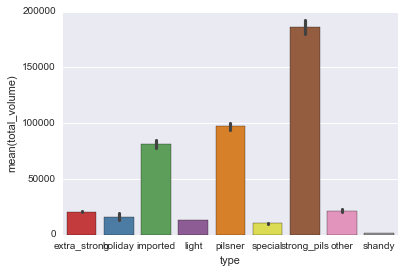

In [316]:
ax = sns.barplot(x="type", y="total_volume", data=aggregated_data)

/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anacon

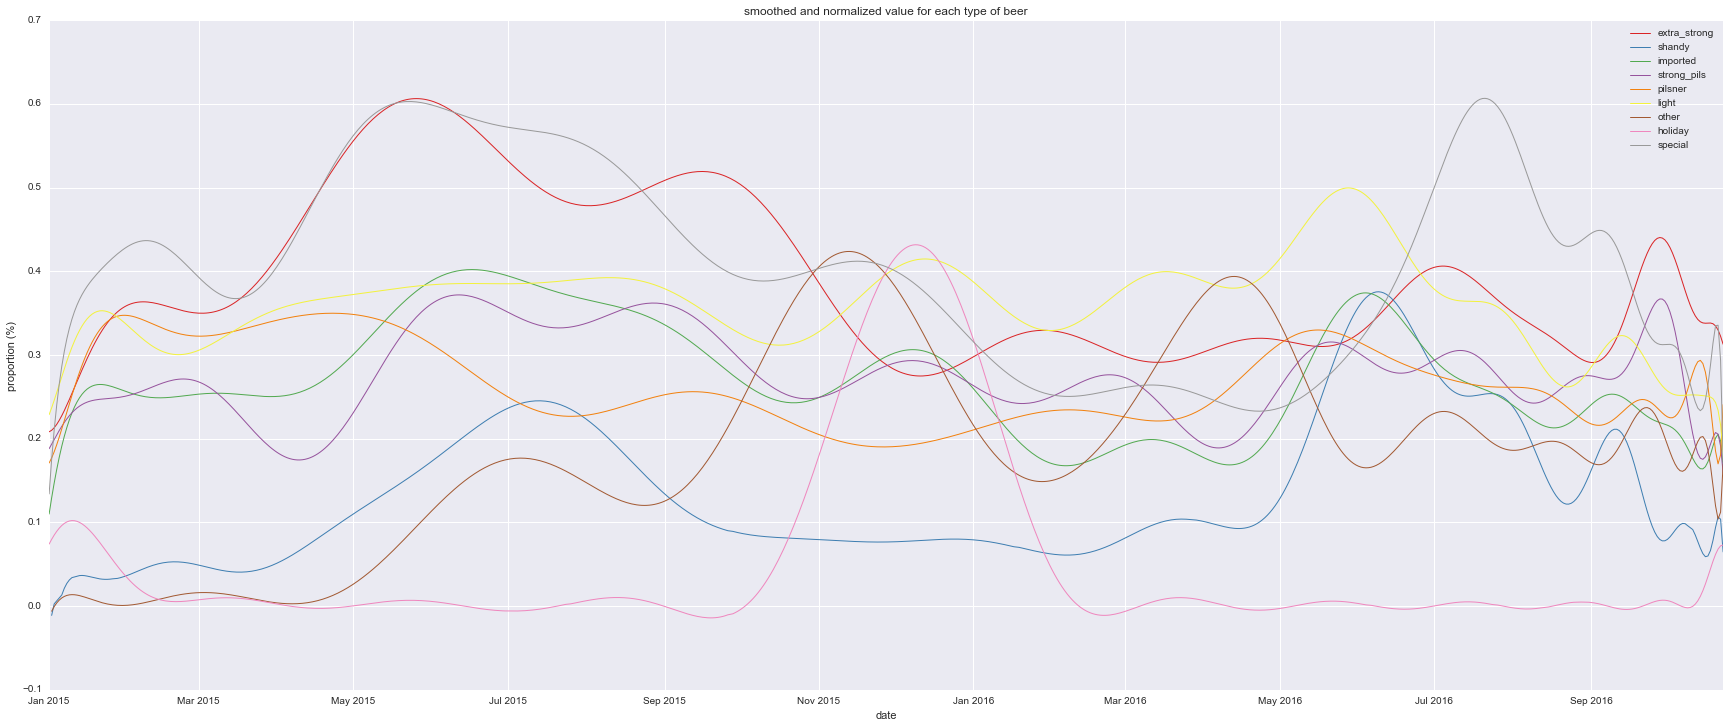

In [317]:
plt.figure(figsize=(30,12))
types = set(aggregated_data['type'])
#types.remove('pilsner')
#types.remove('strong_pils')
sns.set_palette("Set1", len(set(types)), .90)
#types = ['pilsner','imported']
for t in types:
    dd = aggregated_data[ (aggregated_data['type'] == t) ] #& (aggregated_data['date'] > datetime(2016,5,1))  ]
    m = max(dd['total_volume'])
    p = sp.polyfit( range(len(dd)) , dd['total_volume'] / m, deg=100)
    y_ = sp.polyval(p, range(len(dd)))
    #y_ = dd['oms']
    plt.plot_date( dd['date'] , y_ , '-', label = t , linewidth=1)
plt.legend()
plt.title('smoothed and normalized value for each type of beer')
plt.xlabel('date')
plt.ylabel('proportion (%) ')
plt.show()

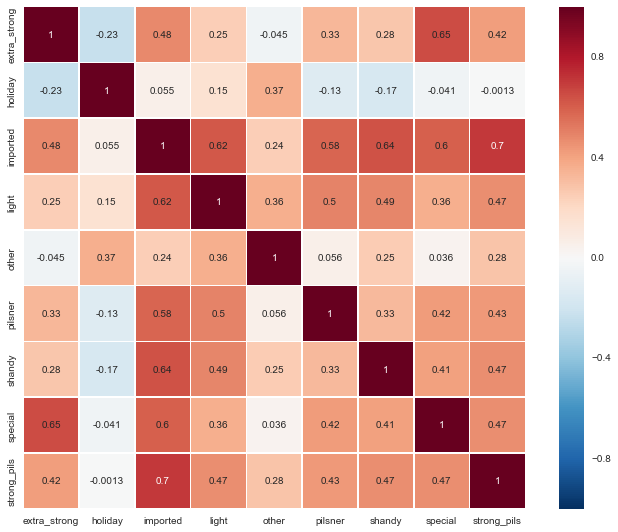

In [319]:
from scipy import stats
#d = aggregated_data[ aggregated_data['station'] == aggregated_data['station'][1] ].set_index('date')
d = aggregated_data.set_index('date')
types = set(d['type'])
series = dict()
for t in types:
    series[t] = d[ d['type'] == t]['total_volume']
    
d = pd.DataFrame(  series )
# Compute the correlation matrix
corrmat = d.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, linewidths=.5)
plt.show()

## Weather and types of beers

In [292]:
df[:3]

,EAN,Produkttekst,avance,chain_store,date,oms,postal_no,store_name,store_no,volume,...,wind,sun,precipitations,weekofyear,month,weekday,dayofyear,year,type,pack
0,5741000116975,Royal B X-mas 6x33ds,1,DagliBrugsen,2015-01-01,31.00,2300,COOP DAGLIBR BRYDES ALLE,1043,1,...,6.1,0,1.9,1,1,3,1,2015,holiday,six_pack
1,5741000131084,Royal Export 6x33 ds,-13,DagliBrugsen,2015-01-01,100.00,2300,COOP DAGLIBR BRYDES ALLE,1043,4,...,6.1,0,1.9,1,1,3,1,2015,strong_pils,six_pack
2,5741000140284,ROYAL PLATINUM 6-PAK,8,DagliBrugsen,2015-01-01,39.95,2300,COOP DAGLIBR BRYDES ALLE,1043,1,...,6.1,0,1.9,1,1,3,1,2015,strong_pils,single


In [332]:
features = ['oms','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station','type', 'total_volume']
q = df[features]
data = q[ q['station'] == q['station'][0] ] #& (q['weekday'] == 4)]

agg = data.groupby(['date','station' ,'type'])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() , 'weekday' :  agg['weekday'].first(), 'total_volume' : agg['total_volume'].sum(), 'temp':agg['temp'].first() , 'sun' : agg['sun'].first(), 'wind' : agg['wind'].first(),  'precipitations' : agg['precipitations'].first() , 'year' : agg['year'].first()  } )
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.sort('date')
aggregated_data.describe()

/Users/valentin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,station,month,precipitations,sun,temp,total_volume,weekday,wind,year
count,5940,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,618800,6.021380,1.860455,4.917811,9.639596,49821.788215,3.009091,3.326077,2015.448653
std,0,3.227948,3.636842,4.458519,6.125940,68309.359137,1.997873,1.692073,0.497398
min,618800,1.000000,0.000000,0.000000,-6.300000,33.000000,0.000000,0.600000,2015.000000
25%,618800,3.000000,0.000000,0.600000,4.600000,6999.000000,1.000000,2.000000,2015.000000
50%,618800,6.000000,0.000000,4.000000,9.500000,17791.500000,3.000000,2.900000,2015.000000
75%,618800,9.000000,2.100000,7.900000,15.000000,71643.000000,5.000000,4.300000,2016.000000
max,618800,12.000000,23.800000,15.900000,23.700000,673679.000000,6.000000,10.000000,2016.000000


In [333]:
aggregated_data[:3]

,type,station,date,month,precipitations,sun,temp,total_volume,weekday,wind,year
0,extra_strong,618800,2015-01-01,1,1.9,0,5.5,5033,3,6.1,2015
1,holiday,618800,2015-01-01,1,1.9,0,5.5,13464,3,6.1,2015
2,imported,618800,2015-01-01,1,1.9,0,5.5,22938,3,6.1,2015


In [363]:
for t in set(aggregated_data['type']):
    i = 0
    print(t)
    dat = aggregated_data[ aggregated_data['type'] == t ]
    dat['bucketed_sun'] = [ 5 * int(v/5) for v in dat['sun'] ]
    dd = dat.groupby('bucketed_sun' )['total_volume'].sum()
    plt.plot( dd.index , dd.values , c = )
plt.show()

SyntaxError: invalid syntax (<ipython-input-363-7bada61cb4b5>, line 7)

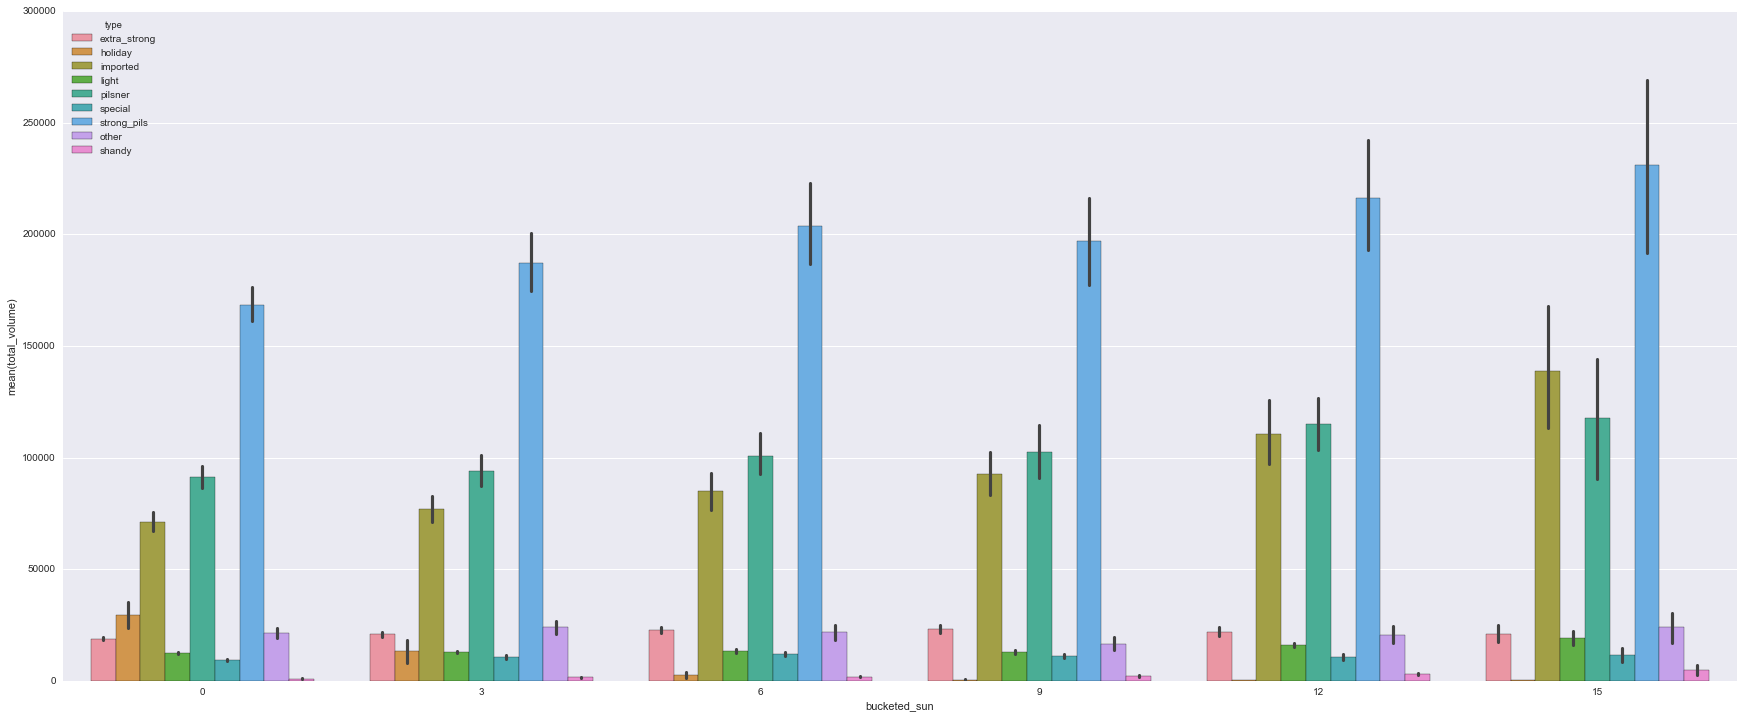

In [379]:
dat = aggregated_data
n = 3
dat['bucketed_sun'] = [ n * int(v/n) for v in dat['sun'] ]
plt.figure(figsize=(30,12))
sns.barplot( x="bucketed_sun" , y="total_volume" , hue='type',data = dat)

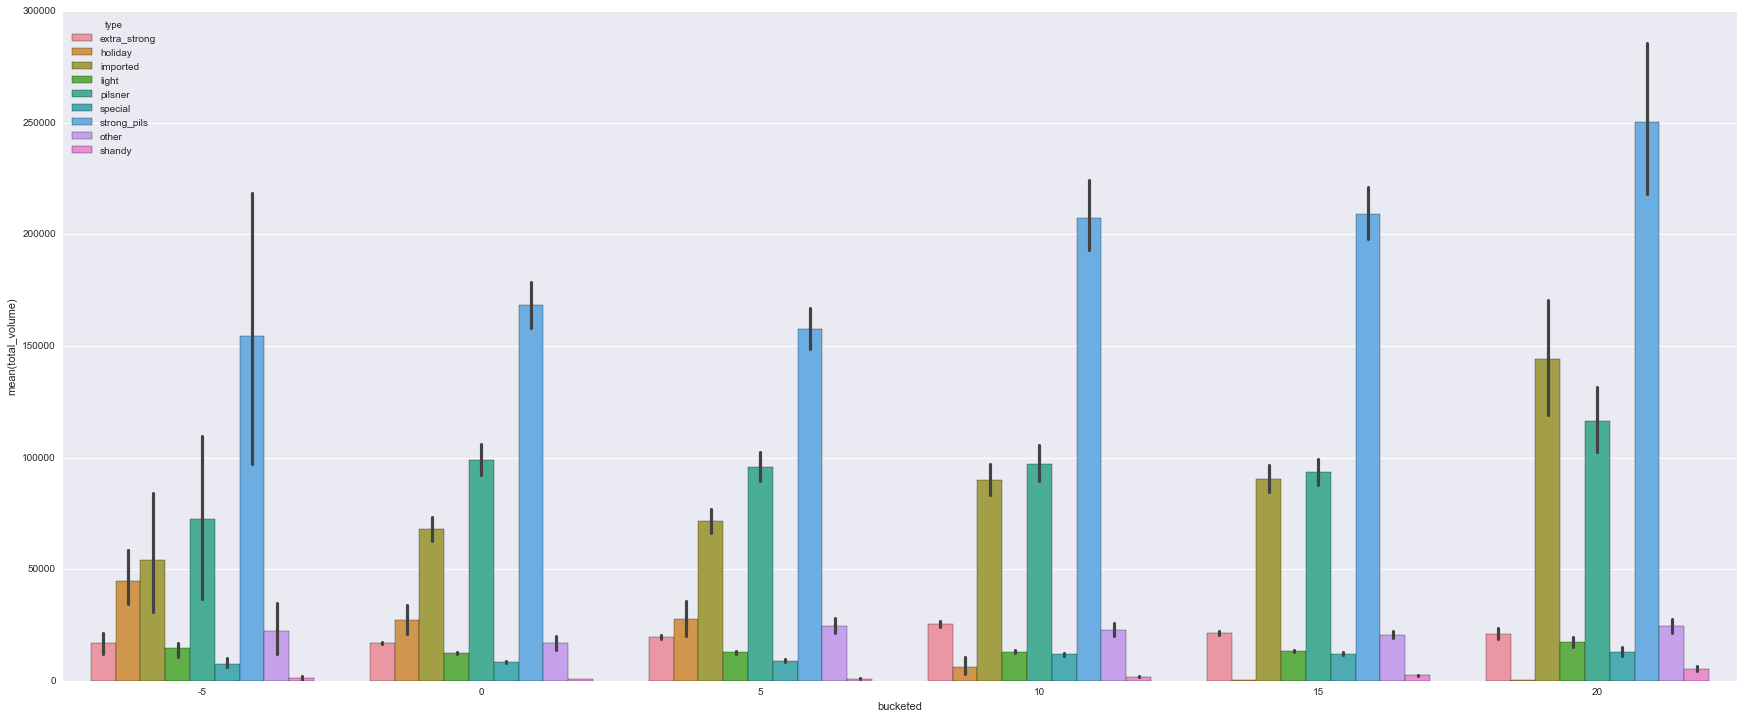

In [380]:
dat = aggregated_data
n = 5
dat['bucketed'] = [ n * int(v/n) for v in dat['temp'] ]
plt.figure(figsize=(30,12))
sns.barplot( x="bucketed" , y="total_volume" , hue='type',data = dat)

# Pack types

In [382]:
features = ['volume','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station','pack','total_volume']
q = df[features]
data = q[ q['station'] == q['station'][0] ] 
# aggregate emp	wind	sun	precipitations
agg = data.groupby(['date','pack'])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() , 'weekday' :  agg['weekday'].first(), 'total_volume' : agg['total_volume'].sum(), 'temp':agg['temp'].first() , 'sun' : agg['sun'].first(), 'wind' : agg['wind'].first(),  'precipitations' : agg['precipitations'].first() , 'year' : agg['year'].first()  } )
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.sort('date')
aggregated_data[:3]

/Users/valentin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,index,pack,date,month,precipitations,sun,temp,total_volume,weekday,wind,year
0,0,crate,2015-01-01,1,1.9,0,5.5,34848,3,6.1,2015
1,1,pint,2015-01-01,1,1.9,0,5.5,11650,3,6.1,2015
2,2,single,2015-01-01,1,1.9,0,5.5,11418,3,6.1,2015


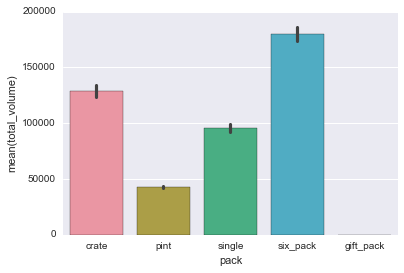

In [383]:
ax = sns.barplot(x="pack", y="total_volume", data=aggregated_data)

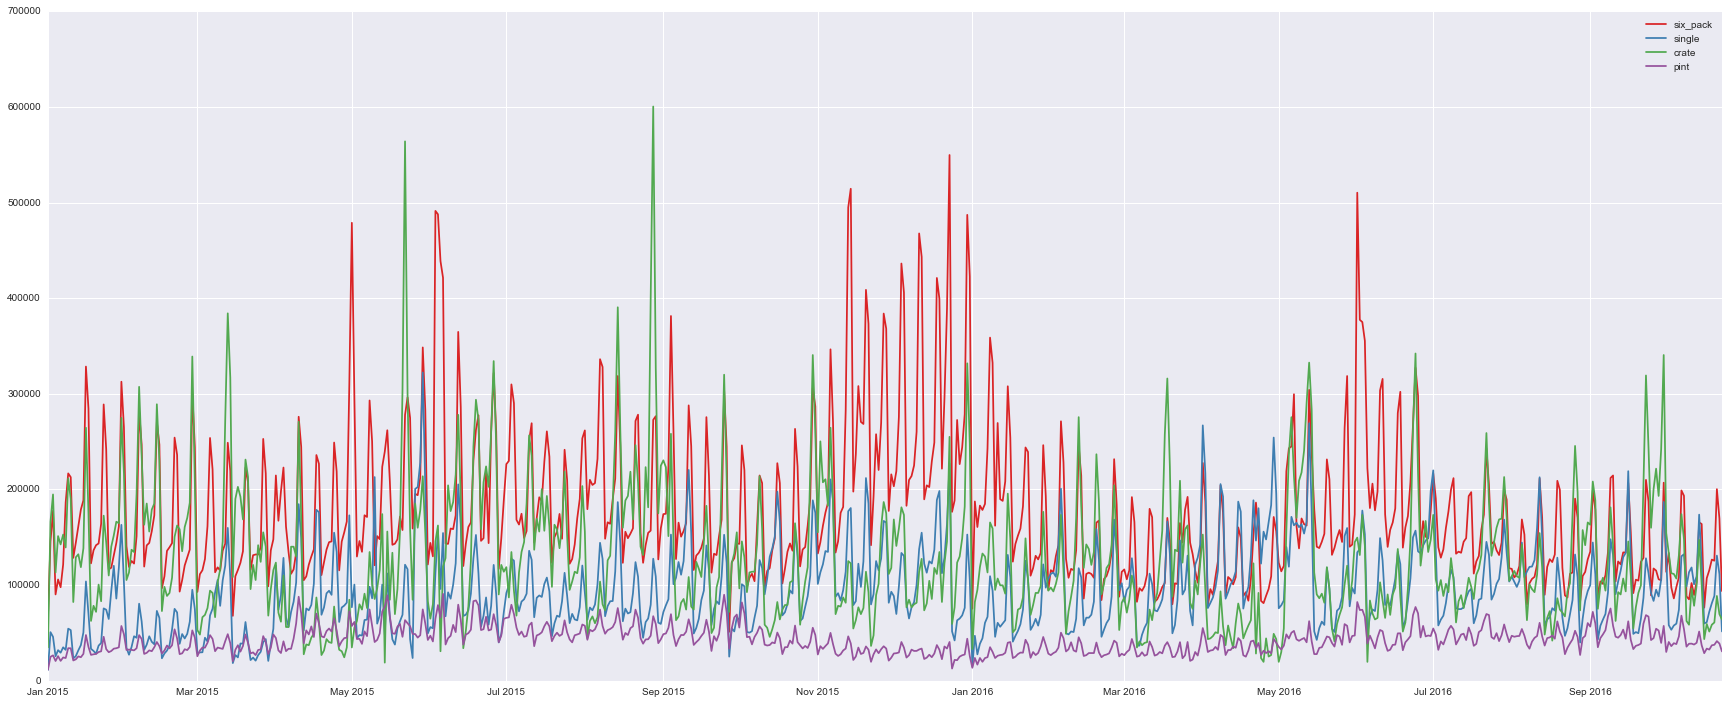

In [384]:
plt.figure(figsize=(30,12))
types = set(aggregated_data['pack'])
types.remove('gift_pack')
#types.remove('strong_pils')
sns.set_palette("Set1", len(set(types)), .90)
#types = ['pilsner','imported']
for t in types:
    dd = aggregated_data[ (aggregated_data['pack'] == t) ] #& (aggregated_data['date'] > datetime(2016,5,1))  ]
    m = max(dd['total_volume'])
    plt.plot_date( dd['date'] , dd['total_volume'] , '-', label = t )
plt.legend()
plt.show()

/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/valentin/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


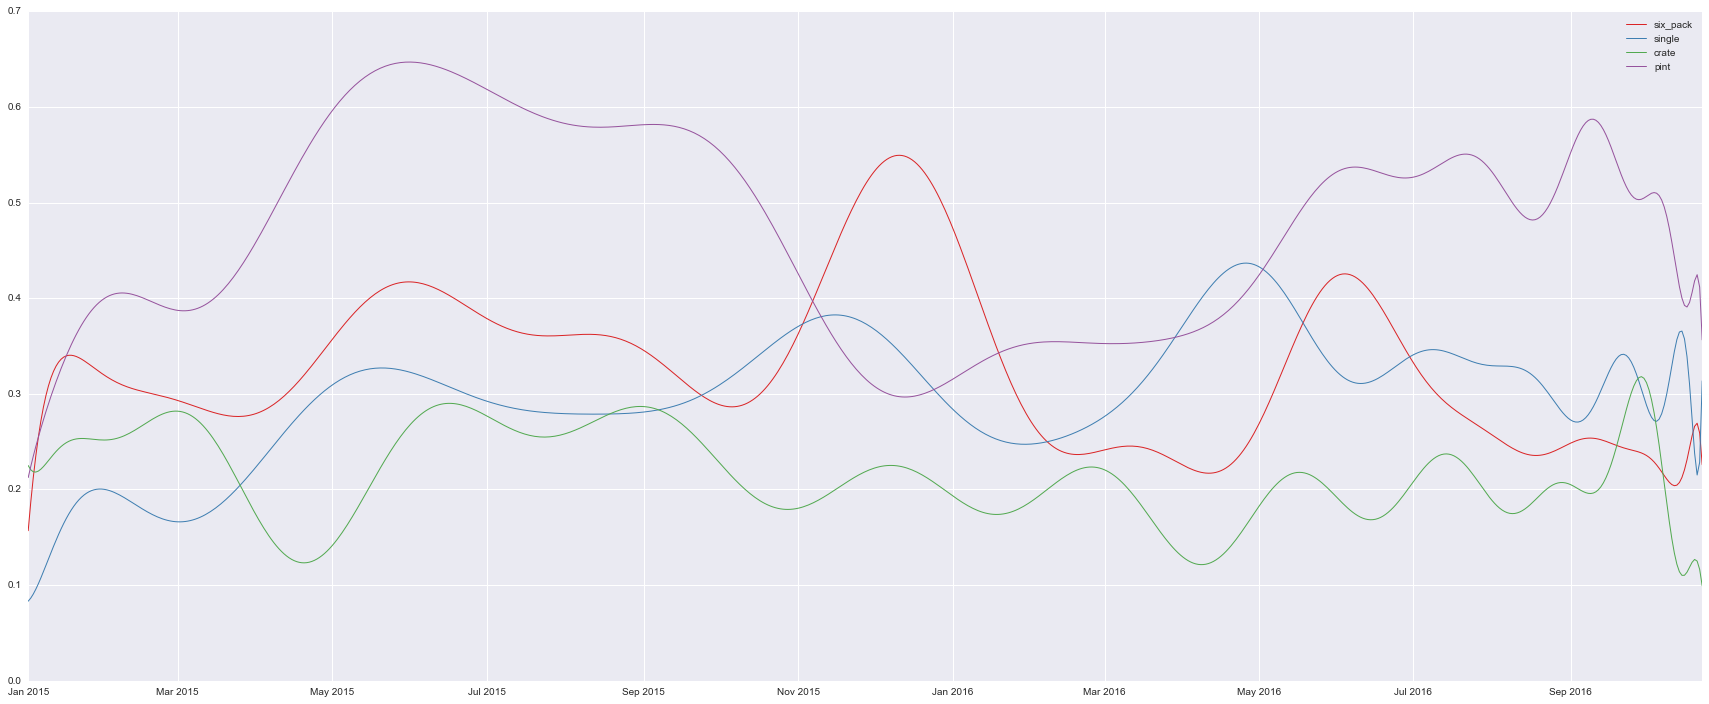

In [385]:
plt.figure(figsize=(30,12))
types = set(aggregated_data['pack'])
types.remove('gift_pack')
#types.remove('pilsner')
#types.remove('strong_pils')
sns.set_palette("Set1", len(set(types)), .90)
#types = ['pilsner','imported']
for t in types:
    dd = aggregated_data[ (aggregated_data['pack'] == t) ] #& (aggregated_data['date'] > datetime(2016,5,1))  ]
    m = max(dd['total_volume'])
    p = sp.polyfit( range(len(dd)) , dd['total_volume'] / m, deg=100)
    y_ = sp.polyval(p, range(len(dd)))
    #y_ = dd['oms']
    plt.plot_date( dd['date'] , y_ , '-', label = t , linewidth=1)
plt.legend()
plt.show()

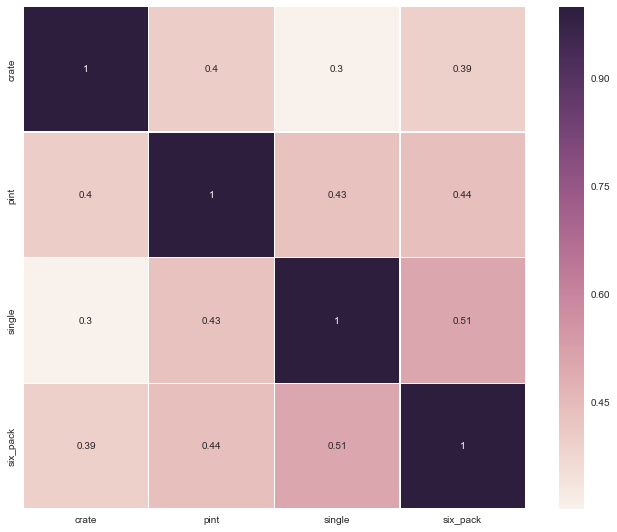

In [386]:
from scipy import stats
#d = aggregated_data[ aggregated_data['station'] == aggregated_data['station'][1] ].set_index('date')
d = aggregated_data.set_index('date')
types = set(d['pack'])
types.remove('gift_pack')
series = dict()
for t in types:
    series[t] = d[ d['pack'] == t]['total_volume']
    
d = pd.DataFrame(  series )
# Compute the correlation matrix
corrmat = d.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, linewidths=.5)
plt.show()

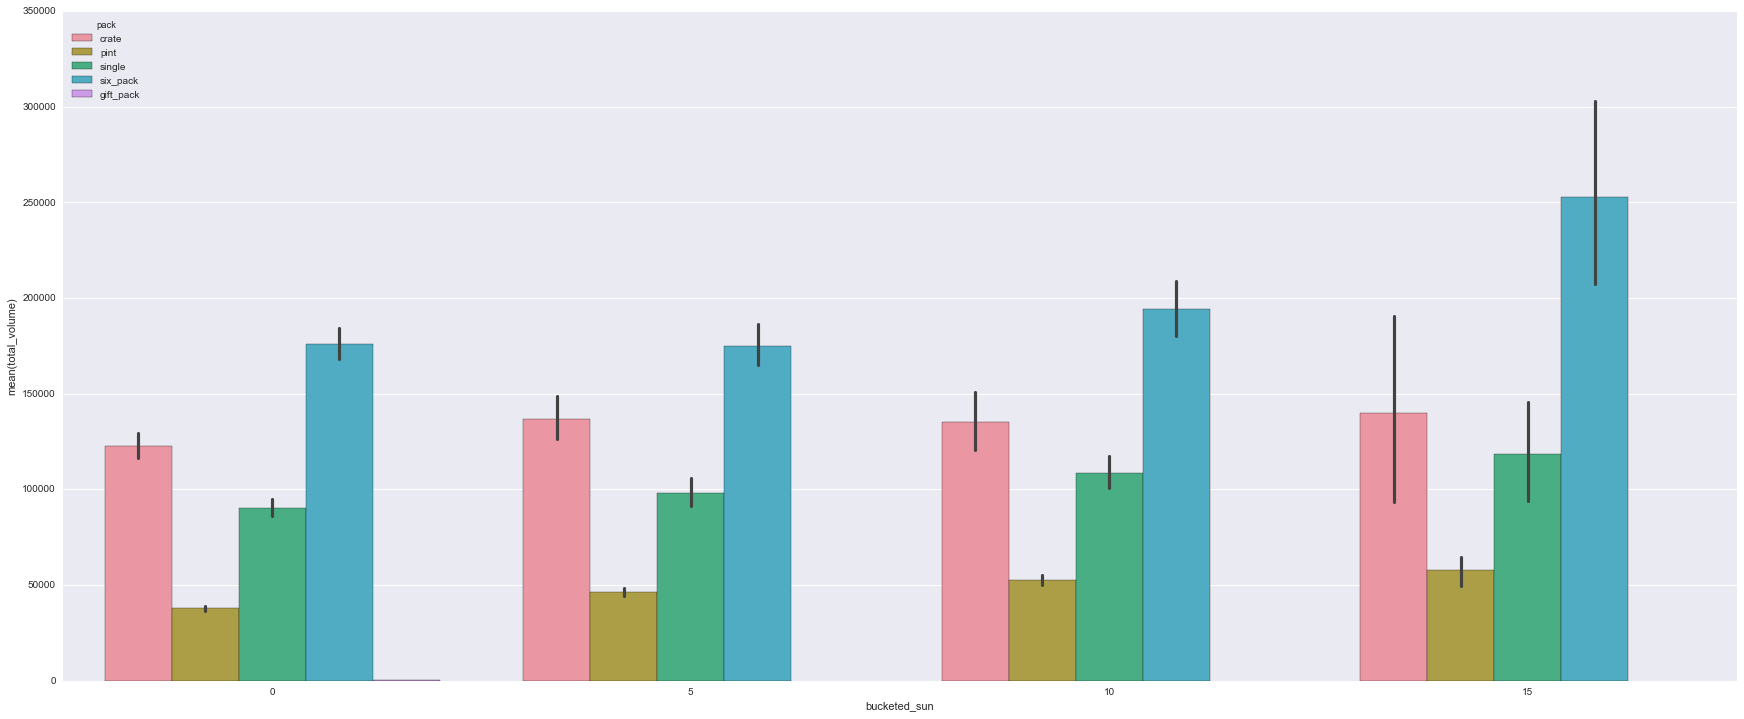

In [401]:
dat = aggregated_data
n = 5
dat['bucketed_sun'] = [ n * int(v/n) for v in dat['sun'] ]
plt.figure(figsize=(30,12))
sns.barplot( x="bucketed_sun" , y="total_volume" , hue='pack',data = dat)

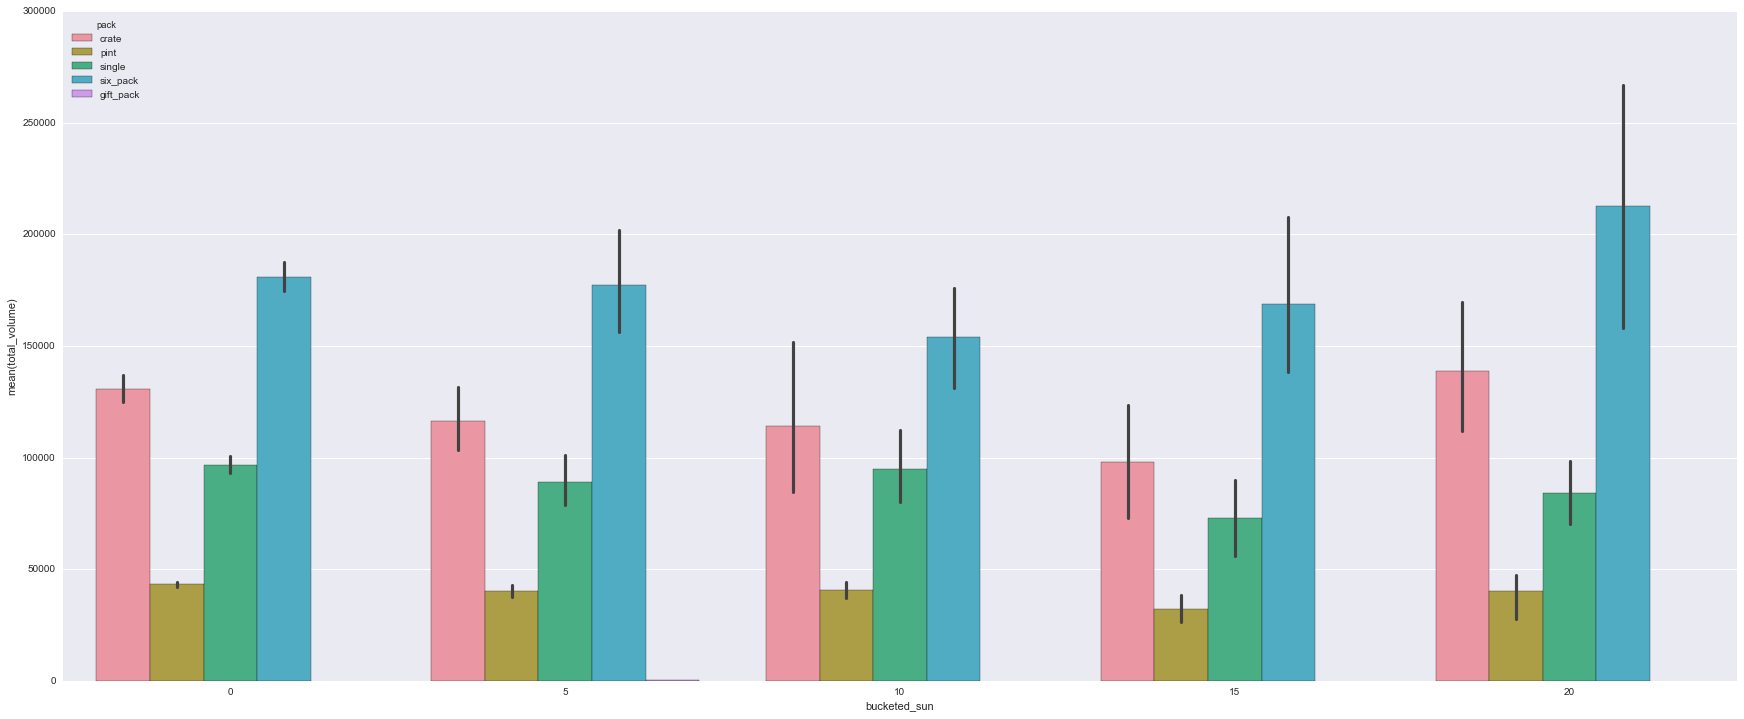

In [398]:
dat = aggregated_data
n = 5
dat['bucketed_sun'] = [ n * int(v/n) for v in dat['precipitations'] ]
plt.figure(figsize=(30,12))
sns.barplot( x="bucketed_sun" , y="total_volume" , hue='pack',data = dat)

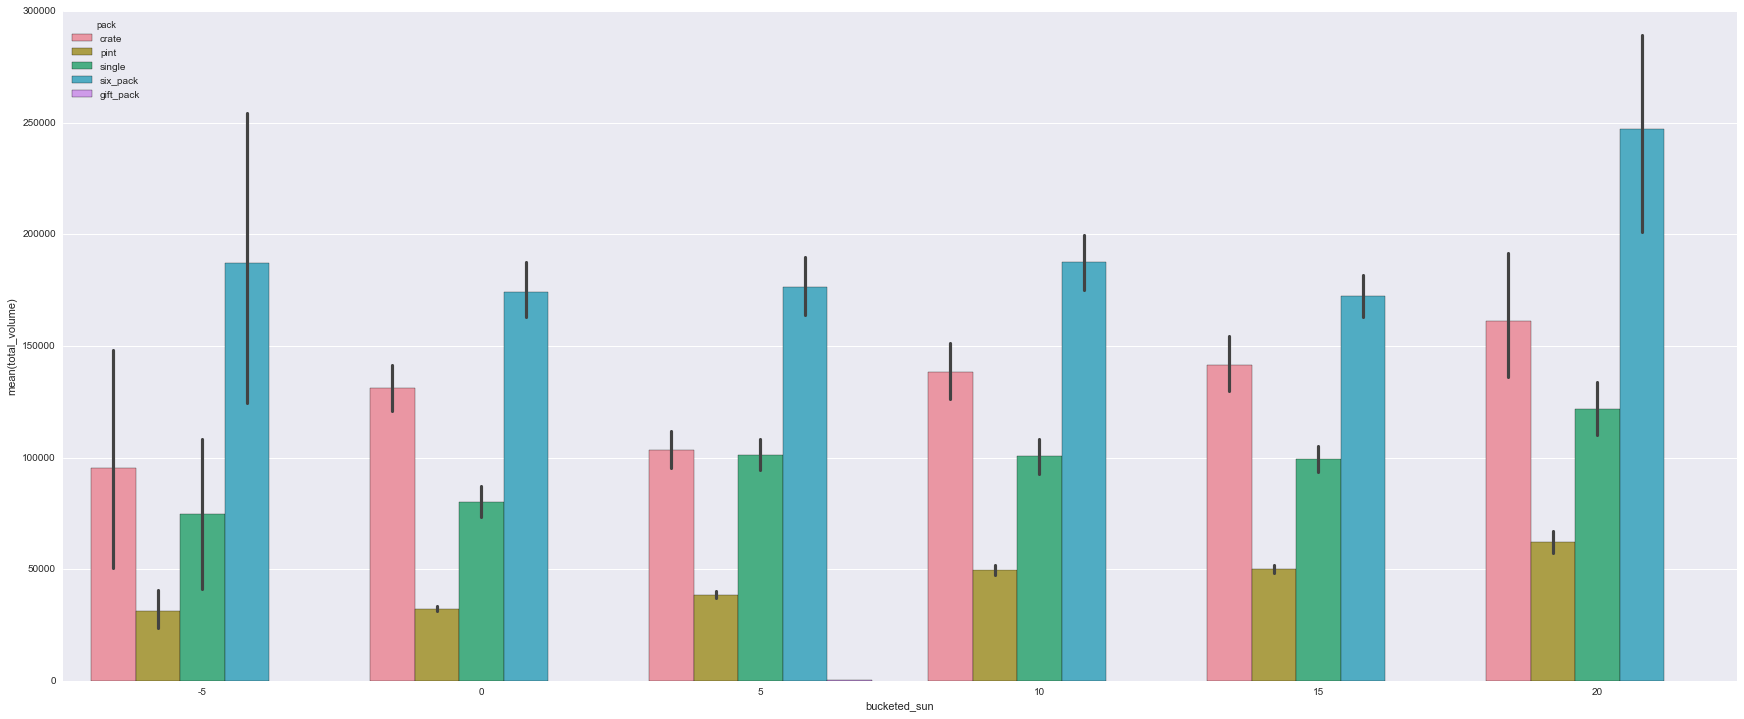

In [399]:
dat = aggregated_data
n = 5
dat['bucketed_sun'] = [ n * int(v/n) for v in dat['temp'] ]
plt.figure(figsize=(30,12))
sns.barplot( x="bucketed_sun" , y="total_volume" , hue='pack',data = dat)